In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os

from mvl2 import genData2
from mvl2.infer import *

set_platform('gpu')

import jax
from jax import numpy as jnp
import jax.numpy as jnp
from jax import random, vmap, pmap

import matplotlib.pyplot as plt

import numpy as np

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from torch import tensor

random_seed = 9939
random_key = random.PRNGKey(random_seed)


plt.style.use('bmh')
if "NUMPYRO_SPHINXBUILD" in os.environ:
    set_matplotlib_formats('svg')

In [3]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))
/home/akotlar/tada/project/mvl2/genData2.py:194: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  alt_counts = tensor(alt_counts)


In [4]:
sim_data["PVDs"].mean(0)

tensor([9.8798e-05, 1.2832e-04, 1.1460e-04, 1.5444e-04], dtype=torch.float64)

In [5]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([9.9663e-05, 9.9663e-05, 9.9663e-05, 9.9663e-05], dtype=torch.float64)
mean affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
std affects 1 tensor([9.6596e-05, 9.7599e-05, 1.9558e-04, 1.9558e-04], dtype=torch.float64)
mean affects 2 tensor([9.4158e-05, 2.9346e-04, 1.9644e-04, 6.0093e-04], dtype=torch.float64)
std affects 2 tensor([9.1781e-05, 2.9517e-04, 1.9454e-04, 6.2857e-04], dtype=torch.float64)
mean affects 3 tensor([9.3318e-05, 2.8553e-04, 9.5279e-05, 2.8553e-04], dtype=torch.float64)
std affects 3 tensor([9.5056e-05, 2.8996e-04, 9.7036e-05, 2.8996e-04], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


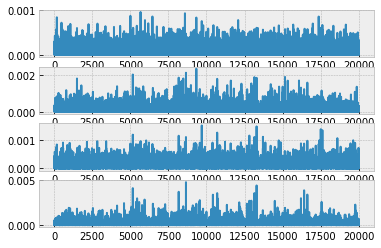

In [6]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [7]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


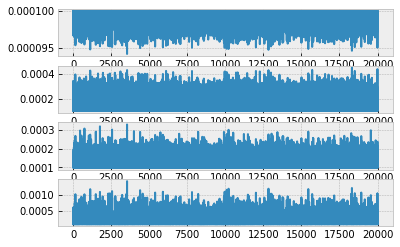

In [8]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


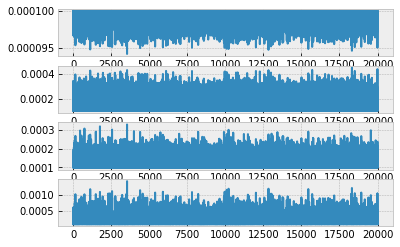

In [9]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [10]:
random_key, _random_key = random.split(random_key)

run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 8000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "accept_prob", "mean_accept_prob"),
}

mcmc_raymond_sim = run_until_enough(random_key=_random_key, run_params=run_params)

best_chain_raymond_sim, statistics_raymond_sim = select_best_chain(mcmc_raymond_sim)
best_weigts_raymond_sim, best_probs_raymond_sim, best_dirichlet_concentrations_raymond_sim = ordered_statistics([best_chain_raymond_sim])

print("best chain's weight mean", best_weigts_raymond_sim.mean(1).mean(0))
print("best chain's probs mean", best_probs_raymond_sim.mean(1).mean(0))

sample: 100%|██████████| 10000/10000 [02:40<00:00, 62.27it/s, 31 steps of size 1.00e-01. acc. prob=0.93]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.64      0.05      0.65      0.58      0.72   1718.98      1.00
                   beta[1]      0.40      0.06      0.40      0.29      0.50   2638.74      1.00
                   beta[2]      0.60      0.10      0.61      0.43      0.77   2120.11      1.00
dirichlet_concentration[0]      3.91      0.94      3.85      2.36      5.40   6135.00      1.00
dirichlet_concentration[1]      2.14      0.74      2.07      0.95      3.28   6899.34      1.00
dirichlet_concentration[2]      1.92      0.68      1.85      0.80      2.94   7154.85      1.00
dirichlet_concentration[3]      1.07      0.44      1.01      0.33      1.72   8489.12      1.00
                probs[0,0]      0.60      0.00      0.60      0.60      0.61   2092.54      1.00
                probs[0,1]      0.18      0.00      0.18      0.17      0.18   4299.20      1.00
                probs[0,2]   

sample: 100%|██████████| 10000/10000 [02:41<00:00, 62.06it/s, 31 steps of size 1.10e-01. acc. prob=0.92] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.65      0.05      0.66      0.58      0.72   1940.69      1.00
                   beta[1]      0.27      0.07      0.26      0.16      0.38   2173.87      1.00
                   beta[2]      0.49      0.08      0.49      0.35      0.62   2305.37      1.00
dirichlet_concentration[0]      3.90      0.95      3.82      2.33      5.40   7275.48      1.00
dirichlet_concentration[1]      2.13      0.75      2.05      0.92      3.31   6943.20      1.00
dirichlet_concentration[2]      1.90      0.66      1.84      0.86      2.93   6879.19      1.00
dirichlet_concentration[3]      1.07      0.43      1.02      0.39      1.75   7658.92      1.00
                probs[0,0]      0.60      0.00      0.60      0.60      0.61   2442.03      1.00
                probs[0,1]      0.18      0.00      0.18      0.17      0.18   4324.25      1.00
                probs[0,2]   

  0%|          | 0/10000 [00:00<?, ?it/s]

inferred stick-breaking weights mean:  [0.6491403  0.09204115 0.12846793 0.1303506 ]
inferred stick-breaking weights stdd:  [0.04542616 0.01836299 0.0445957  0.02086293]


sample: 100%|██████████| 10000/10000 [02:27<00:00, 67.86it/s, 31 steps of size 1.24e-01. acc. prob=0.91]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.02      0.09      0.06      0.12   2318.56      1.00
                   beta[1]      0.72      0.05      0.73      0.64      0.81   1771.46      1.00
                   beta[2]      0.53      0.08      0.53      0.39      0.67   2222.01      1.00
dirichlet_concentration[0]      3.92      0.92      3.84      2.38      5.33   7321.29      1.00
dirichlet_concentration[1]      2.14      0.74      2.07      0.93      3.29   8069.26      1.00
dirichlet_concentration[2]      1.92      0.66      1.86      0.80      2.89   8231.63      1.00
dirichlet_concentration[3]      1.07      0.44      1.02      0.35      1.72  10870.72      1.00
                probs[0,0]      0.33      0.01      0.33      0.31      0.35   2980.52      1.00
                probs[0,1]      0.30      0.01      0.30      0.28      0.31   5854.65      1.00
                probs[0,2]   

  0%|          | 0/10000 [00:00<?, ?it/s]

inferred stick-breaking weights mean:  [0.09165511 0.65478015 0.13236561 0.12119912]
inferred stick-breaking weights stdd:  [0.01819839 0.04364615 0.0208435  0.04270387]


sample: 100%|██████████| 10000/10000 [02:40<00:00, 62.37it/s, 31 steps of size 1.10e-01. acc. prob=0.91]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.63      0.05      0.64      0.56      0.71   1678.61      1.00
                   beta[1]      0.38      0.08      0.38      0.26      0.51   1679.27      1.00
                   beta[2]      0.63      0.08      0.63      0.49      0.76   2164.94      1.00
dirichlet_concentration[0]      3.91      0.93      3.83      2.33      5.34   7762.72      1.00
dirichlet_concentration[1]      2.13      0.74      2.06      0.94      3.30   7932.46      1.00
dirichlet_concentration[2]      1.91      0.66      1.85      0.84      2.96   6734.09      1.00
dirichlet_concentration[3]      1.07      0.44      1.02      0.36      1.75   8507.19      1.00
                probs[0,0]      0.60      0.01      0.60      0.60      0.61   2126.70      1.00
                probs[0,1]      0.18      0.00      0.18      0.17      0.18   4533.41      1.00
                probs[0,2]   

In [12]:
run_params2 = run_params.copy()
run_params2['model_to_run'] = model
mcmc_raymond_sim_old = run_until_enough(random_key=_random_key, run_params=run_params2, target_number_of_chains=1)


sample: 100%|██████████| 10000/10000 [02:18<00:00, 72.13it/s, 31 steps of size 1.11e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.66      0.04      0.67      0.60      0.73   2005.41      1.00
   beta[1]      0.40      0.06      0.40      0.29      0.50   2820.71      1.00
   beta[2]      0.45      0.11      0.45      0.28      0.64   2030.45      1.00
probs[0,0]      0.60      0.00      0.60      0.60      0.61   2537.28      1.00
probs[0,1]      0.18      0.00      0.17      0.17      0.18   4375.17      1.00
probs[0,2]      0.18      0.00      0.18      0.17      0.18   2225.10      1.00
probs[0,3]      0.05      0.00      0.05      0.04      0.05   3075.04      1.00
probs[1,0]      0.42      0.01      0.42      0.41      0.44   4536.20      1.00
probs[1,1]      0.36      0.01      0.36      0.35      0.38   3937.62      1.00
probs[1,2]      0.13      0.01      0.13      0.11      0.14   3178.22      1.00
probs[1,3]      0.09      0.01      0.09      0.08      0.10   3452.93      1.00
probs[2,0]      0.33      0

In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.1_pi2_0.1_pi12_0.1_h2_1_0.2_h2_2_0.2_rho_0/results.csv')

#df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.022515,0.02302,0.001295])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

In [6]:
stat_data_dave

array([[29,  2,  1,  0],
       [30,  1,  0,  0],
       [47,  3,  1,  0],
       ...,
       [30,  0,  1,  0],
       [34,  1,  1,  0],
       [46,  1,  1,  0]])

In [19]:
# with better initial prevalence; half the divergences, much larger n_eff
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key,sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [02:41<00:00,  7.42it/s, 511 steps of size 1.15e-02. acc. prob=0.86]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.08      0.12    343.30      1.00
   beta[1]      0.85      0.02      0.86      0.82      0.88    237.50      1.00
   beta[2]      0.83      0.06      0.84      0.74      0.91    168.85      1.01
probs[0,0]      0.88      0.00      0.88      0.88      0.89    392.00      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.05    270.67      1.01
probs[0,2]      0.07      0.00      0.07      0.06      0.07    465.71      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    307.13      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    560.67      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    345.96      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02    657.44      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00    495.13      1.00
probs[2,0]      0.90      0

In [9]:
# just a re-run
# with better initial prevalence; half the divergences, much larger n_eff
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [02:23<00:00,  8.34it/s, 255 steps of size 6.21e-03. acc. prob=0.77]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.01      0.02      0.01      0.05     40.14      1.00
   beta[1]      0.10      0.01      0.10      0.08      0.12    190.23      1.00
   beta[2]      0.13      0.02      0.13      0.10      0.16    185.20      1.04
probs[0,0]      0.93      0.01      0.93      0.92      0.94    218.24      1.01
probs[0,1]      0.00      0.00      0.00      0.00      0.01     50.78      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    125.69      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00    126.34      1.01
probs[1,0]      0.88      0.00      0.88      0.88      0.89    123.19      1.00
probs[1,1]      0.04      0.00      0.04      0.04      0.05    122.72      1.01
probs[1,2]      0.07      0.00      0.07      0.06      0.07    205.46      1.01
probs[1,3]      0.01      0.00      0.01      0.01      0.01    123.95      1.00
probs[2,0]      0.90      0

In [10]:
# re-run again, to see effect of random variability on performance
random_key, _random_key = random.split(random_key)

mcmc_dave, inferred_params_dave = run(_random_key, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [04:28<00:00,  4.46it/s, 1023 steps of size 4.40e-03. acc. prob=0.90]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.02      0.11      0.09      0.14    362.04      1.00
   beta[1]      0.04      0.02      0.04      0.02      0.07     22.22      1.00
   beta[2]      0.89      0.02      0.89      0.87      0.92     74.45      1.00
probs[0,0]      0.90      0.00      0.90      0.90      0.91    181.42      1.00
probs[0,1]      0.07      0.00      0.07      0.06      0.07    145.65      1.00
probs[0,2]      0.03      0.00      0.03      0.02      0.03    855.39      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.01    673.66      1.00
probs[1,0]      0.92      0.01      0.92      0.91      0.93     86.39      1.01
probs[1,1]      0.01      0.00      0.01      0.00      0.01     21.69      1.01
probs[1,2]      0.07      0.01      0.07      0.06      0.08    216.17      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.00     16.61      1.01
probs[2,0]      0.95      0

In [15]:
# With warmup pruning, seems to hurt performance, slightly, or maybe nto affect ti
random_key, _random_key = random.split(random_key)

run_params_dave_pruned = run_params_dave.copy()
run_params_dave_pruned['thinning'] = 2

mcmc_dave_pruned, inferred_params_dave_pruned = run(_random_key, run_params=run_params_dave_pruned)

sample: 100%|██████████| 1200/1200 [03:07<00:00,  6.40it/s, 255 steps of size 6.63e-03. acc. prob=0.89] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.08      0.12    195.16      1.00
   beta[1]      0.12      0.02      0.12      0.10      0.15    276.86      1.01
   beta[2]      0.04      0.02      0.03      0.01      0.07     85.21      1.00
probs[0,0]      0.88      0.00      0.88      0.88      0.89     91.60      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.05     78.84      1.00
probs[0,2]      0.07      0.00      0.07      0.06      0.07    300.57      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01    159.09      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    262.01      1.02
probs[1,1]      0.07      0.00      0.07      0.06      0.07    353.35      1.02
probs[1,2]      0.03      0.00      0.02      0.02      0.03    274.03      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    172.04      1.00
probs[2,0]      0.93      0

In [ ]:
# Our best performing model; fits like a champ even challening simulations
random_key, _random_key = random.split(random_key)

run_params_dave_2k_8k_gamma8 = run_params_dave.copy()
run_params_dave_2k_8k_gamma8['num_warmup'] = 2000
run_params_dave_2k_8k_gamma8['num_samples'] = 8000
run_params_dave_2k_8k_gamma8['model_to_run'] = model_with_gamma_prior_alpha8

mcmc_dave_2k_8k_gamma8 = run_until_enough(random_key=_random_key, run_params=run_params_dave_2k_8k_gamma8)

sample: 100%|██████████| 10000/10000 [02:48<00:00, 59.21it/s, 63 steps of size 7.89e-02. acc. prob=0.89]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.09      0.01      0.09      0.07      0.12   2635.47      1.00
                   beta[1]      0.83      0.02      0.84      0.80      0.87   2424.66      1.00
                   beta[2]      0.74      0.07      0.74      0.62      0.86   2377.34      1.00
dirichlet_concentration[0]      6.68      1.06      6.61      4.96      8.38   8439.27      1.00
dirichlet_concentration[1]      0.61      0.26      0.58      0.20      0.99   5660.21      1.00
dirichlet_concentration[2]      0.71      0.29      0.68      0.26      1.17   8071.63      1.00
dirichlet_concentration[3]      0.26      0.13      0.24      0.07      0.45   6060.18      1.00
                probs[0,0]      0.88      0.00      0.88      0.87      0.89   2346.73      1.00
                probs[0,1]      0.05      0.00      0.05      0.04      0.05   1933.27      1.00
                probs[0,2]   

sample:  91%|█████████ | 9072/10000 [02:38<00:14, 62.09it/s, 31 steps of size 8.82e-02. acc. prob=0.90]  

In [ ]:
best_chain, statistics = select_best_chain(mcmc_dave_2k_warmup_4k_samples_gamma8)
print(statistics)
best_weights, best_probs, best_dirichlet_concentrations = ordered_statistics([best_chain])
del mcmc_dave_2k_warmup_4k_samples_gamma8

In [ ]:
best_probs_mean_rounded = round_it(best_probs.mean(1).mean(0))

best_probs_mean_rounded_df = pd.DataFrame(best_probs_mean_rounded, columns=['P(~D|V,H)', 'P(D1|V,H)', 'P(D2|V,H)', 'P(D12|V,H)' ])
best_probs_mean_rounded_df

In [3]:
# TODO: automate this using numpy or pandas queries, by maximizing the difference between penetrance 
assumed_h0 = best_probs_mean_rounded_df['P(~D|V,H)'].idxmax()
assumed_h1 = (best_probs_mean_rounded_df['P(D1|V,H)'] - best_probs_mean_rounded_df['P(D2|V,H)']).idxmax() #(case1 > case2)
assumed_h2 = (best_probs_mean_rounded_df['P(D2|V,H)'] - best_probs_mean_rounded_df['P(D1|V,H)']).idxmax() #(case2 > case1)
assumed_h12 = (best_probs_mean_rounded_df['P(D12|V,H)']).idxmax()
print("h0", assumed_h0, 'h1', assumed_h1, 'h2', assumed_h2, 'h12', assumed_h12)

best_probs_mean_rounded_df.index = ["H0", "H1", "H2", "H12"]
best_probs_mean_rounded_df

NameError: name 'best_probs_mean_rounded_df' is not defined

In [407]:
np.expand_dims(best_weights[0][:,assumed_h0], 1)

array([[0.7337045 ],
       [0.71722114],
       [0.7045096 ],
       ...,
       [0.7590045 ],
       [0.79781467],
       [0.7556322 ]], dtype=float32)

In [397]:
best_probs[0][:,assumed_h0,:]

array([[0.9554641 , 0.02217955, 0.02107051, 0.00128582],
       [0.95515376, 0.02236311, 0.02115103, 0.00133209],
       [0.9562013 , 0.02152015, 0.02099997, 0.00127857],
       ...,
       [0.95387137, 0.02335148, 0.02139166, 0.00138549],
       [0.9532702 , 0.02323762, 0.02205042, 0.00144176],
       [0.9539767 , 0.02303733, 0.02154814, 0.00143784]], dtype=float32)

In [419]:
PD_H0 = np.expand_dims(best_weights[0][:,assumed_h0], 1) * best_probs[0][:,assumed_h0,:]
print(PD_H0)
PD_H0 = PD_H0.sum(1).mean(0)
print("PD_H0", PD_H0)

PD_H1 = np.expand_dims(best_weights[0][:,assumed_h1], 1) * best_probs[0][:,assumed_h1,:]
print(PD_H1)
PD_H1 = PD_H1.sum(1).mean(0)
print("PD_H1", PD_H1)

[[0.70102835 0.01627323 0.01545953 0.00094341]
 [0.68505645 0.0160393  0.01516997 0.0009554 ]
 [0.673653   0.01516115 0.01479468 0.00090077]
 ...
 [0.72399265 0.01772388 0.01623636 0.00105159]
 [0.7605329  0.01853931 0.01759215 0.00115026]
 [0.72085553 0.01740775 0.01628247 0.00108648]]
[[0.11166856 0.00776197 0.0032427  0.00058028]
 [0.11265019 0.0074309  0.003018   0.00057746]
 [0.12891005 0.00872663 0.003808   0.00062461]
 ...
 [0.0842397  0.00632654 0.00212264 0.00040647]
 [0.07421169 0.00616556 0.00214261 0.00040504]
 [0.07371198 0.00577834 0.00174233 0.00033409]]


In [333]:
best_probs[0][:,assumed_h0].mean(0)

array([0.95442194, 0.0224636 , 0.02171964, 0.00139545], dtype=float32)

In [369]:
best_weights[0].shape

(4000, 4)

In [410]:
(best_weights[0][:,assumed_h0] * best_probs[0][:,assumed_h0]).mean(0).mean(0)

ValueError: operands could not be broadcast together with shapes (4000,) (4000,4) 

In [315]:
# random_key, _random_key = random.split(random_key)
#P(H0|D) = P(D|H0)P(H0)
H0_posterior = (best_weights[0][:,assumed_h0] @ best_probs[0][:,assumed_h0]).mean(0).mean(0)
#P(H1|D) = P(D|H1)P(H1)


best_weights[0][:,assumed_h0].mean()

0.050556492

In [263]:
!pip install sigfig

In [271]:
from sigfig import round
print(round(.0025, sigfigs = 2))

0.0025


In [189]:
best_weights.mean(1).mean(0)

array([0.75074273, 0.11462137, 0.08499584, 0.05055654], dtype=float32)

In [190]:
best_weights.std(1).mean(0)

array([0.02441647, 0.02254469, 0.02133291, 0.02352615], dtype=float32)

In [167]:
best_probs.mean(1).mean(0)

array([[0.95442194, 0.0224636 , 0.02171964, 0.00139545],
       [0.90523845, 0.06540862, 0.02482527, 0.00452901],
       [0.87843716, 0.04691708, 0.06731693, 0.00732881],
       [0.9213348 , 0.01135538, 0.06576426, 0.00154604]], dtype=float32)

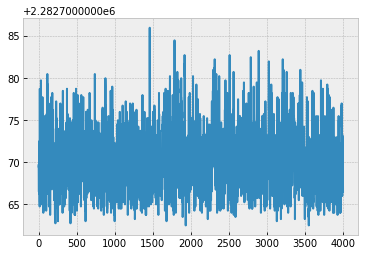

In [173]:
plt.plot(best_chain.get_extra_fields()['potential_energy'][0])

In [88]:
# For comparison, using the model with no prior on the dirichlet concentrations
random_key, _random_key = random.split(random_key)
run_params_dave_2k_4k = run_params_dave.copy()
run_params_dave_2k_4k['num_warmup'] = 2000
run_params_dave_2k_4k['num_samples'] = 4000
mcmc_dave2k_warmup_4k_sample_4chains = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_dave_2k_4k)
mcmc_dave2k_warmup_4k_sample_4chains

  0%|          | 0/6000 [00:00<?, ?it/s]

[1393185219  222562721]


  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.10      0.01      0.10      0.09      0.12     36.83      1.04
   beta[1]      0.12      0.01      0.13      0.10      0.15    383.13      1.01
   beta[2]      0.97      0.01      0.97      0.95      0.98     10.61      1.20
probs[0,0]      0.88      0.00      0.88      0.88      0.89    521.20      1.00
probs[0,1]      0.04      0.00      0.04      0.04      0.04     49.64      1.02
probs[0,2]      0.07      0.00      0.07      0.06      0.07    283.88      1.01
probs[0,3]      0.01      0.00      0.01      0.01      0.01     72.23      1.03
probs[1,0]      0.90      0.00      0.90      0.90      0.91    137.57      1.01
probs[1,1]      0.07      0.00      0.07      0.06      0.07    141.03      1.02
probs[1,2]      0.03      0.00      0.03      0.02      0.03    217.39      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01     29.09      1.07
probs[2,0]      0.95      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.03      0.02      0.02      0.01      0.06    118.27      1.01
   beta[1]      0.12      0.02      0.11      0.09      0.14   1250.46      1.00
   beta[2]      0.11      0.01      0.11      0.09      0.14    713.36      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    389.78      1.00
probs[0,1]      0.00      0.01      0.00      0.00      0.01     92.68      1.01
probs[0,2]      0.07      0.01      0.07      0.06      0.08   1012.04      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00    201.26      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    847.19      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07   1311.47      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    968.75      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    857.33      1.00
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.77      0.01      0.77      0.74      0.79    352.60      1.01
   beta[1]      0.48      0.05      0.48      0.41      0.56    723.09      1.00
   beta[2]      0.83      0.04      0.84      0.77      0.90    395.84      1.00
probs[0,0]      0.95      0.00      0.95      0.95      0.96    350.03      1.01
probs[0,1]      0.02      0.00      0.02      0.02      0.02    368.03      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    835.73      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1053.01      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    630.98      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    468.36      1.01
probs[1,2]      0.03      0.00      0.03      0.02      0.03    943.90      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    930.08      1.00
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.01      0.02      0.02      0.03      5.66      1.47
   beta[1]      0.12      0.01      0.12      0.09      0.14    222.99      1.01
   beta[2]      0.12      0.01      0.12      0.10      0.14     91.11      1.07
probs[0,0]      0.93      0.01      0.93      0.92      0.94     83.70      1.08
probs[0,1]      0.00      0.00      0.00      0.00      0.01      7.16      1.36
probs[0,2]      0.07      0.01      0.07      0.06      0.08     14.50      1.21
probs[0,3]      0.00      0.00      0.00      0.00      0.00     62.16      1.06
probs[1,0]      0.90      0.00      0.90      0.90      0.91    121.97      1.05
probs[1,1]      0.07      0.00      0.07      0.06      0.07     64.12      1.07
probs[1,2]      0.03      0.00      0.03      0.02      0.03    160.15      1.02
probs[1,3]      0.01      0.00      0.01      0.00      0.01      9.75      1.28
probs[2,0]      0.89      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.11      0.01      0.11      0.09      0.13    438.94      1.00
   beta[1]      0.86      0.01      0.86      0.84      0.88    534.89      1.00
   beta[2]      0.84      0.04      0.84      0.77      0.88     33.29      1.03
probs[0,0]      0.90      0.00      0.90      0.90      0.91     95.78      1.01
probs[0,1]      0.07      0.00      0.07      0.06      0.07    290.85      1.00
probs[0,2]      0.03      0.00      0.03      0.02      0.03    354.86      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.01   1010.11      1.00
probs[1,0]      0.95      0.00      0.95      0.95      0.96    459.98      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    456.00      1.00
probs[1,2]      0.02      0.00      0.02      0.02      0.02    469.52      1.01
probs[1,3]      0.00      0.00      0.00      0.00      0.00    391.68      1.01
probs[2,0]      0.88      0

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.76      0.02      0.76      0.74      0.79    734.55      1.00
   beta[1]      0.47      0.05      0.47      0.39      0.55    878.11      1.00
   beta[2]      0.22      0.09      0.19      0.11      0.36    151.46      1.01
probs[0,0]      0.95      0.00      0.95      0.95      0.96   1287.85      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02   1303.65      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    900.29      1.01
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1367.55      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    750.57      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    951.16      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    961.67      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    928.40      1.00
probs[2,0]      0.93      0

sample: 100%|██████████| 6000/6000 [02:44<00:00, 36.54it/s, 15 steps of size 4.27e-02. acc. prob=0.73] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.02      0.00      0.02      0.01      0.03    381.98      1.00
   beta[1]      0.11      0.01      0.11      0.09      0.14    495.45      1.00
   beta[2]      0.12      0.01      0.12      0.10      0.14    358.57      1.00
probs[0,0]      0.93      0.01      0.93      0.92      0.94    790.56      1.00
probs[0,1]      0.00      0.00      0.00      0.00      0.00    307.75      1.00
probs[0,2]      0.07      0.01      0.07      0.06      0.08    686.31      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1071.99      1.00
probs[1,0]      0.90      0.00      0.90      0.90      0.91    630.94      1.00
probs[1,1]      0.07      0.00      0.07      0.06      0.07    583.35      1.00
probs[1,2]      0.03      0.00      0.03      0.02      0.03    569.14      1.00
probs[1,3]      0.00      0.00      0.00      0.00      0.01    760.78      1.00
probs[2,0]      0.88      0

In [253]:
df_exp2 = pd.read_csv('sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.6_h2_2_0.8_rho_0.8/results.csv')
pds_exp2 = np.array([0.03669,0.043745,0.00995])
pd_with_both_exp2 = np.array([1 - pds.sum(), *pds])
n_samples_exp2 = 200_000
n_cases_exp2 = n_samples * pds
n_ctrls_exp2 = n_samples - n_cases.sum()

run_params_exp2 = {
    "data": df_exp2.to_numpy(),
    "n_cases": n_cases_exp2,
    "n_ctrls": n_ctrls_exp2,
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 4000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

random_key, _random_key = random.split(random_key)

mcmc_exp2 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp2)

best_chain_exp2, statistics_exp2 = select_best_chain(mcmc_exp2)
best_weigts_exp2, best_probs_exp2, best_dirichlet_concentrations_exp2 = ordered_statistics([best_chain_exp2])

print("best chain's weight mean", best_weigts_exp2.mean(1).mean(0))
print("best chain's probs mean", best_probs_exp2.mean(1).mean(0))

warmup:  16%|█▋        | 978/6000 [00:05<00:26, 192.00it/s, 7 steps of size 5.02e-01. acc. prob=0.79]  


KeyboardInterrupt: 

In [196]:
random_key, _random_key = random.split(random_key)

run_params_exp2_with_gamma_prior = run_params_exp2.copy()
run_params_exp2_with_gamma_prior['model_to_run'] = model_with_gamma_prior_alpha8
mcmc_exp2_gamma_prior = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp2_with_gamma_prior)

best_chain_exp2_gamma_prior, statistics_exp2_gamma_prior = select_best_chain(mcmc_exp2_gamma_prior)
best_weights_exp2_gamma_prior, best_probs_exp2_gamma_prior, best_dirichlet_concentrations_exp2_gamma_prior = ordered_statistics([best_chain_exp2_gamma_prior])

print("best chain's weight mean", best_weights_exp2_gamma_prior.mean(1).mean(0))
print("best chain's probs mean", best_probs_exp2_gamma_prior.mean(1).mean(0))

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   4979.94      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.04   5538.53      1.00
                   beta[2]      0.05      0.00      0.05      0.04      0.05   4719.41      1.00
dirichlet_concentration[0]      5.76      0.99      5.69      4.16      7.36   4671.85      1.00
dirichlet_concentration[1]      0.89      0.36      0.85      0.34      1.45   5055.45      1.00
dirichlet_concentration[2]      0.79      0.33      0.74      0.24      1.28   5384.91      1.00
dirichlet_concentration[3]      0.59      0.26      0.55      0.14      0.95   5836.30      1.00
                probs[0,0]      0.73      0.00      0.73      0.73      0.74   5143.77      1.00
                probs[0,1]      0.23      0.00      0.23      0.23      0.24   4548.38      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.88      0.00      0.88      0.87      0.88   4162.14      1.00
                   beta[1]      0.30      0.01      0.30      0.29      0.32   4697.24      1.00
                   beta[2]      0.50      0.02      0.50      0.48      0.53   3796.78      1.00
dirichlet_concentration[0]      5.77      0.99      5.71      4.19      7.41   4521.24      1.00
dirichlet_concentration[1]      0.90      0.38      0.84      0.29      1.48   5421.43      1.00
dirichlet_concentration[2]      0.79      0.33      0.75      0.25      1.28   4500.95      1.00
dirichlet_concentration[3]      0.59      0.26      0.55      0.16      0.98   5564.87      1.00
                probs[0,0]      0.93      0.00      0.93      0.93      0.93   4728.65      1.00
                probs[0,1]      0.03      0.00      0.03      0.03      0.03   5614.32      1.00
                probs[0,2]   

  0%|          | 0/6000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   6236.28      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.04   5224.79      1.00
                   beta[2]      0.95      0.00      0.95      0.95      0.96   5608.63      1.00
dirichlet_concentration[0]      5.75      1.00      5.71      4.13      7.35   6260.06      1.00
dirichlet_concentration[1]      0.89      0.36      0.84      0.35      1.48   8760.82      1.00
dirichlet_concentration[2]      0.78      0.32      0.74      0.29      1.28   7038.53      1.00
dirichlet_concentration[3]      0.59      0.27      0.55      0.19      1.01   6956.23      1.00
                probs[0,0]      0.65      0.00      0.65      0.65      0.66   6126.36      1.00
                probs[0,1]      0.15      0.00      0.15      0.14      0.15   8473.21      1.00
                probs[0,2]   

sample: 100%|██████████| 6000/6000 [00:29<00:00, 201.95it/s, 7 steps of size 5.32e-01. acc. prob=0.87] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.05   5160.28      1.00
                   beta[1]      0.92      0.00      0.92      0.91      0.92   4674.86      1.00
                   beta[2]      0.53      0.02      0.53      0.51      0.56   6240.32      1.00
dirichlet_concentration[0]      5.73      0.97      5.67      4.14      7.33   6972.98      1.00
dirichlet_concentration[1]      0.89      0.36      0.85      0.27      1.39   7537.77      1.00
dirichlet_concentration[2]      0.79      0.33      0.75      0.28      1.30   7434.20      1.00
dirichlet_concentration[3]      0.59      0.27      0.55      0.18      1.00   7048.74      1.00
                probs[0,0]      0.65      0.00      0.65      0.65      0.66   5462.00      1.00
                probs[0,1]      0.15      0.00      0.15      0.14      0.15   8439.12      1.00
                probs[0,2]   

In [197]:
print("for gamma prior, best chain's weight mean", best_weights_exp2_gamma_prior.mean(1).mean(0))
print("for gamm prior, best chain's probs mean", best_probs_exp2_gamma_prior.mean(1).mean(0))

print("not gamma prior, best chain's weight mean", best_weigts_exp2.mean(1).mean(0))
print("not gamma prior, best chain's probs mean", best_probs_exp2.mean(1).mean(0))

for gamma prior, best chain's weight mean [0.8771469  0.04316266 0.04290941 0.0375005 ]
for gamm prior, best chain's probs mean [[0.9272771  0.03450252 0.02787636 0.01034338]
 [0.651673   0.14768691 0.09963744 0.10100234]
 [0.73054856 0.23067245 0.01325674 0.02552276]
 [0.76653963 0.01663832 0.18970007 0.02712189]]
not gamma prior, best chain's weight mean [0.8772848  0.04300627 0.04299101 0.03733756]
not gamma prior, best chain's probs mean [[0.9272761  0.03450213 0.02787862 0.01034363]
 [0.651556   0.14768074 0.09968692 0.10107711]
 [0.7307009  0.23055248 0.01324366 0.02550363]
 [0.7665162  0.01659535 0.18975748 0.02713047]]


In [209]:
(best_weights_exp2_gamma_prior[0] @ best_probs_exp2_gamma_prior[0]).mean(1).mean(0)

array([0.9015793 , 0.04716037, 0.03643494, 0.01554444], dtype=float32)

In [214]:
best_probs_exp2_gamma_prior[0]

array([[[0.9281005 , 0.03426833, 0.02729929, 0.01033185],
        [0.65258014, 0.14879139, 0.0998134 , 0.09881505],
        [0.73051584, 0.22977328, 0.01374554, 0.02596533],
        [0.7618948 , 0.01479586, 0.19692174, 0.02638757]],

       [[0.92738867, 0.03459146, 0.02770223, 0.01031765],
        [0.656564  , 0.14685203, 0.09919571, 0.09738827],
        [0.7345957 , 0.2262343 , 0.01364291, 0.02552707],
        [0.7582833 , 0.01537116, 0.19894516, 0.02740037]],

       [[0.9275896 , 0.0343949 , 0.02776237, 0.01025313],
        [0.65967405, 0.14355244, 0.09811344, 0.09866006],
        [0.7346457 , 0.2265148 , 0.01386136, 0.02497811],
        [0.75904495, 0.01540002, 0.19801174, 0.02754331]],

       ...,

       [[0.92719895, 0.03433115, 0.02793932, 0.01053058],
        [0.6559515 , 0.14598976, 0.09823062, 0.0998281 ],
        [0.73879004, 0.22182254, 0.0135666 , 0.02582082],
        [0.76417315, 0.01688367, 0.19221564, 0.02672755]],

       [[0.927214  , 0.03418   , 0.02810866, 0.0104

In [200]:
df_exp2_np = df_exp2.to_numpy()
(df_exp2_np / df_exp2_np.sum(1)[:, np.newaxis]).mean(0)

array([0.90109938, 0.04702912, 0.03637225, 0.01549926])

In [210]:
pd_with_both_exp2

array([0.95317 , 0.022515, 0.02302 , 0.001295])

In [171]:
print('P(D|V,H0)', probs_ordered_exp2_2_with_conc.mean(1).mean(0)[0])

P(D|V,H0) [0.9272734  0.03450265 0.02787912 0.01034489]


In [168]:
probs_ordered_exp2_2_with_conc.shape

(4, 4000, 4, 4)

In [201]:
import numpyro.distributions as dist
# order doesn't matter for mixture models
with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for (weights, probs, conc) in get_statistics_permutations(mcmc_exp2_2_with_conc, 4):

        mixing_dist = dist.Categorical(probs=weights.mean(1).mean(0))

        component_dist = dist.Multinomial(probs=probs.mean(1).mean(0))

        mixture = dist.MixtureSameFamily(mixing_dist, component_dist)

        res = mixture.log_prob(run_params_exp2_with_conc['data'])
        print("done:", res.sum())
        print(res)

order [0 1 2 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 1 3 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 2 1 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 2 3 1]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 3 1 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [0 3 2 1]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 0 2 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 0 3 2]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 2 0 3]
done: -2316369.0
[-172.2869  -122.85404 -113.7233  ...  -81.47652 -110.79109 -151.48137]
order [1 2 3 0]
done: -2316369.0
[-172.2869  -122.85404

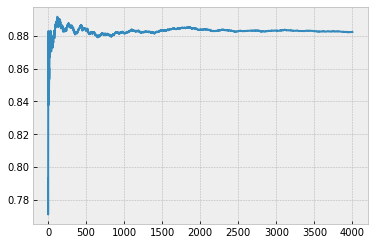

In [224]:
plt.plot(best_chain_exp2.get_extra_fields()['mean_accept_prob'])

In [235]:
best_chain_exp2.get_extra_fields()['mean_accept_prob'].std()

DeviceArray(0.00333409, dtype=float32)

In [236]:
best_chain_exp2.get_extra_fields()['accept_prob'].std()

DeviceArray(0.11648113, dtype=float32)

In [238]:
from numpyro.infer import Predictive

random_key, random_key_ = random.split(random_key)
prior_predictive = Predictive(model_with_gamma_prior_alpha7, num_samples=100)
# prior_predictions = prior_predictive(rng_key_, marriage=dset.MarriageScaled.values)['obs']
# mean_prior_pred = jnp.mean(prior_predictions, axis=0)
# hpdi_prior_pred = hpdi(prior_predictions, 0.9)

# ax = plot_regression(dset.MarriageScaled.values, mean_prior_pred, hpdi_prior_pred)
# ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Predictions with 90% CI');

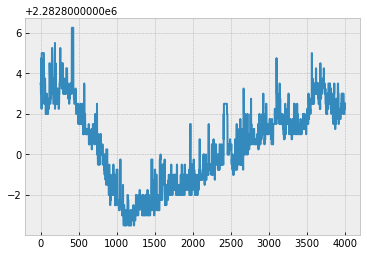

In [112]:
plt.plot(mcmc_dave_2k_warmup_4k_samples2.get_extra_fields(group_by_chain=True)['potential_energy'][0])


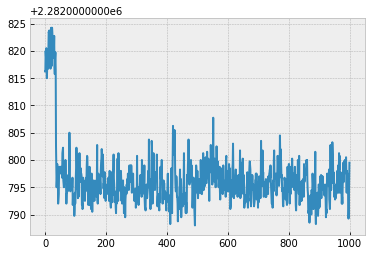

In [ ]:
dave_4chain_potential_energy = mcmc_dave.get_extra_fields(group_by_chain=True)['potential_energy']
plt.plot(dave_4chain_potential_energy[0])

In [254]:
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')

run_params_exp3 = {
    "data": df.to_numpy(),
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 2000,
    "num_samples": 8000,
    "num_chains": 1,
    "max_K": 4,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model_with_gamma_prior_alpha8,
    "jit_model_args": False,
    "extra_fields": ("potential_energy", "energy", "accept_prob", "mean_accept_prob"),
}

random_key, _random_key = random.split(random_key)

mcmc_exp3 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_exp3)

best_chain_exp3, statistics_exp3 = select_best_chain(mcmc_exp3)
best_weights_exp3, best_probs_exp3, best_dirichlet_concentrations_exp3 = ordered_statistics([best_chain_exp3])

print("best chain's weight mean", best_weights_exp3.mean(1).mean(0))
print("best chain's probs mean", best_probs_exp3.mean(1).mean(0))


  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.04  13680.01      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05  13173.42      1.00
                   beta[2]      0.96      0.00      0.96      0.95      0.96  12111.15      1.00
dirichlet_concentration[0]      5.55      0.97      5.49      3.88      7.07  12578.10      1.00
dirichlet_concentration[1]      0.83      0.34      0.79      0.31      1.39  13813.55      1.00
dirichlet_concentration[2]      0.83      0.34      0.78      0.28      1.35  13663.08      1.00
dirichlet_concentration[3]      0.64      0.28      0.60      0.18      1.05  13201.99      1.00
                probs[0,0]      0.62      0.00      0.62      0.62      0.63  13318.16      1.00
                probs[0,1]      0.12      0.00      0.12      0.12      0.13  14532.63      1.00
                probs[0,2]   

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.04  11944.44      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05  11213.57      1.00
                   beta[2]      0.96      0.00      0.96      0.95      0.96   9113.91      1.00
dirichlet_concentration[0]      5.56      0.97      5.50      4.00      7.10   9741.68      1.00
dirichlet_concentration[1]      0.84      0.34      0.80      0.29      1.37  12111.08      1.00
dirichlet_concentration[2]      0.83      0.34      0.79      0.31      1.36  11247.59      1.00
dirichlet_concentration[3]      0.64      0.28      0.60      0.19      1.05  11643.94      1.00
                probs[0,0]      0.62      0.00      0.62      0.62      0.63  11319.21      1.00
                probs[0,1]      0.12      0.00      0.12      0.12      0.13  12864.19      1.00
                probs[0,2]   

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.04   7876.85      1.00
                   beta[1]      0.91      0.00      0.91      0.91      0.92   9271.46      1.00
                   beta[2]      0.50      0.01      0.50      0.48      0.52   8331.19      1.00
dirichlet_concentration[0]      5.59      0.98      5.52      3.95      7.12   8268.75      1.00
dirichlet_concentration[1]      0.84      0.34      0.79      0.30      1.37  10462.83      1.00
dirichlet_concentration[2]      0.83      0.34      0.79      0.28      1.34   8900.41      1.00
dirichlet_concentration[3]      0.64      0.28      0.61      0.20      1.06   8920.87      1.00
                probs[0,0]      0.73      0.00      0.73      0.72      0.73   8646.94      1.00
                probs[0,1]      0.23      0.00      0.23      0.22      0.23   7114.72      1.00
                probs[0,2]   

sample: 100%|██████████| 10000/10000 [00:34<00:00, 293.06it/s, 7 steps of size 5.49e-01. acc. prob=0.86]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.04      0.00      0.04      0.04      0.04  13629.34      1.00
                   beta[1]      0.04      0.00      0.04      0.04      0.05  14743.79      1.00
                   beta[2]      0.04      0.00      0.04      0.04      0.05  14348.42      1.00
dirichlet_concentration[0]      5.57      0.99      5.52      3.90      7.09  16074.19      1.00
dirichlet_concentration[1]      0.84      0.35      0.80      0.28      1.37  16513.15      1.00
dirichlet_concentration[2]      0.82      0.33      0.78      0.29      1.34  15299.07      1.00
dirichlet_concentration[3]      0.64      0.28      0.60      0.23      1.09  14175.20      1.00
                probs[0,0]      0.62      0.00      0.62      0.62      0.63  14065.29      1.00
                probs[0,1]      0.12      0.00      0.12      0.12      0.13  16131.59      1.00
                probs[0,2]   

In [1]:
best_weights_exp3 = best_weigts_exp3

NameError: name 'best_weigts_exp3' is not defined

In [2]:
best_probs_exp3

NameError: name 'best_probs_exp3' is not defined

In [ ]:

def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = df.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, "o")
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# Compute empirical posterior distribution over mu
posterior_probs = best_probs_exp3.mean(1)
posterior_weights = best_weights_exp3.mean(1)

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(
    xlabel="Marriage rate", ylabel="Divorce rate", title="Regression line with 90% CI"
);



In [ ]:
mcmc_dave, inferred_params_dave= run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [00:07<00:00, 166.12it/s, 7 steps of size 3.88e-01. acc. prob=0.90] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88    703.44      1.00
   beta[1]      0.33      0.01      0.33      0.32      0.35    791.51      1.00
   beta[2]      0.50      0.01      0.50      0.48      0.53   1031.01      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.92   1381.03      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   1694.36      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1788.45      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   1346.82      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   1177.90      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.02   1782.41      1.00
probs[1,2]      0.22      0.00      0.22      0.22      0.23   1061.52      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.03    730.31      1.00
probs[2,0]      0.73      0

In [255]:
run_params_dave50 = run_params_exp3.copy()
run_params_dave50['max_K'] = 50

random_key, _random_key = random.split(random_key)

mcmc_exp3_50 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_dave50)

best_chain_exp3_50, statistics_exp3_50 = select_best_chain(mcmc_exp3_50)
best_weigts_exp3_50, best_probs_exp3_50, best_dirichlet_concentrations_exp3_50 = ordered_statistics([best_chain_exp3_50])

print("best chain's weight mean", best_weigts_exp3_50.mean(1).mean(0))
print("best chain's probs mean", best_probs_exp3_50.mean(1).mean(0))

sample: 100%|██████████| 10000/10000 [01:17<00:00, 129.00it/s, 3 steps of size 2.59e-02. acc. prob=0.76] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.02      0.00      0.02      0.01      0.02      4.41      1.55
                   beta[1]      0.02      0.00      0.02      0.02      0.03     20.57      1.04
                   beta[2]      0.03      0.00      0.03      0.02      0.03      4.36      1.84
                   beta[3]      0.04      0.00      0.04      0.03      0.04     32.28      1.00
                   beta[4]      0.03      0.00      0.03      0.02      0.04     10.76      1.01
                   beta[5]      0.98      0.00      0.98      0.98      0.99      8.91      1.03
                   beta[6]      0.74      0.06      0.75      0.65      0.83     14.84      1.07
                   beta[7]      0.91      0.05      0.92      0.83      0.98     36.26      1.01
                   beta[8]      0.81      0.20      0.89      0.51      1.00     61.44      1.03
                   beta[9]   

  0%|          | 0/10000 [00:00<?, ?it/s]

inferred stick-breaking weights mean:  [1.87955443e-02 2.46507619e-02 2.57756822e-02 3.53834517e-02
 2.67608557e-02 8.55531752e-01 1.01837395e-02 3.40054603e-03
 3.69104207e-04 1.70881671e-04 1.37681607e-04 6.68003704e-05
 7.65033983e-05 1.09875073e-04 2.38468056e-05 1.22070276e-04
 5.34882493e-05 8.20514324e-05 1.12160582e-04 1.23131511e-04
 1.14443414e-04 1.01953628e-04 6.85700725e-05 4.77691101e-05
 1.23188016e-04 1.10648070e-04 1.22757148e-04 1.24983970e-04
 1.24810584e-04 1.13273738e-04 1.15349423e-04 1.00583813e-04
 1.04769009e-04 1.20872406e-04 1.18496515e-04 4.88987316e-05
 3.12399061e-05 1.06662374e-04 8.90215306e-05 1.19992110e-04
 1.20538440e-04 1.17617921e-04 3.90771129e-05 2.32683647e-06
 3.61136299e-05 7.46117657e-05 7.00836026e-05 1.02860664e-04
 8.42333757e-05 1.24984377e-04]
inferred stick-breaking weights stdd:  [0.01147531 0.01105475 0.01088296 0.01017621 0.01034762 0.0046472
 0.0086769  0.0104319  0.01103985 0.01062868 0.0107312  0.0050852
 0.00670869 0.00977689 0.0

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.00      0.00      0.00      0.00      0.00     17.85      1.09
                   beta[1]      0.02      0.01      0.02      0.01      0.03      4.28      1.65
                   beta[2]      0.01      0.00      0.01      0.01      0.02     15.84      1.00
                   beta[3]      0.87      0.02      0.88      0.84      0.90      4.84      1.70
                   beta[4]      0.17      0.04      0.17      0.10      0.24      6.69      1.49
                   beta[5]      0.29      0.07      0.30      0.16      0.40      4.24      1.38
                   beta[6]      0.00      0.00      0.00      0.00      0.01      9.12      1.22
                   beta[7]      0.30      0.19      0.32      0.01      0.53      4.25      1.42
                   beta[8]      0.50      0.17      0.46      0.27      0.79      2.97      2.09
                   beta[9]   

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.02      0.00      0.02      0.01      0.03     33.22      1.03
                   beta[1]      0.00      0.00      0.00      0.00      0.01     18.60      1.01
                   beta[2]      0.65      0.19      0.74      0.36      0.86      2.99      2.10
                   beta[3]      0.51      0.20      0.47      0.23      0.84      2.62      2.46
                   beta[4]      0.15      0.05      0.14      0.07      0.22      8.82      1.31
                   beta[5]      0.17      0.13      0.15      0.00      0.35     14.14      1.01
                   beta[6]      0.28      0.03      0.28      0.24      0.34     18.08      1.06
                   beta[7]      0.32      0.04      0.31      0.27      0.39      8.76      1.17
                   beta[8]      0.39      0.05      0.39      0.30      0.48      9.26      1.01
                   beta[9]   

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.01      0.00      0.01      0.00      0.02      7.40      1.04
                   beta[1]      0.03      0.01      0.03      0.02      0.04      4.81      1.49
                   beta[2]      0.02      0.00      0.02      0.01      0.02     14.22      1.03
                   beta[3]      0.03      0.00      0.03      0.02      0.03     27.96      1.04
                   beta[4]      0.86      0.12      0.90      0.79      0.93      8.76      1.14
                   beta[5]      0.03      0.01      0.02      0.01      0.05      3.76      2.11
                   beta[6]      0.22      0.12      0.22      0.02      0.38      6.11      1.66
                   beta[7]      0.25      0.09      0.24      0.10      0.40      5.87      1.38
                   beta[8]      0.15      0.10      0.17      0.02      0.29      2.64      2.76
                   beta[9]   

sample: 100%|██████████| 10000/10000 [02:20<00:00, 71.20it/s, 14 steps of size 1.07e-02. acc. prob=0.84] 



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.86      0.00      0.86      0.85      0.86     15.28      1.20
                   beta[1]      0.19      0.02      0.19      0.15      0.22      9.85      1.12
                   beta[2]      0.29      0.02      0.29      0.26      0.32     29.72      1.00
                   beta[3]      0.28      0.04      0.28      0.22      0.34      8.38      1.09
                   beta[4]      0.21      0.04      0.22      0.15      0.26      8.88      1.01
                   beta[5]      0.54      0.07      0.53      0.43      0.66      5.80      1.71
                   beta[6]      0.84      0.07      0.85      0.75      0.96     17.56      1.03
                   beta[7]      0.12      0.09      0.10      0.01      0.24     26.99      1.00
                   beta[8]      0.94      0.10      0.98      0.83      1.00     96.81      1.00
                   beta[9]   

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave503 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave503, inferred_params_dave503= run(sim_data={}, run_params=run_params_dave503)

sample: 100%|██████████| 1200/1200 [00:30<00:00, 39.85it/s, 18 steps of size 8.19e-02. acc. prob=0.70] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00     10.23      1.08
    beta[1]      0.02      0.00      0.02      0.02      0.02      8.45      1.14
    beta[2]      0.02      0.00      0.02      0.02      0.03     17.81      1.00
    beta[3]      0.03      0.00      0.03      0.02      0.03     19.94      1.00
    beta[4]      0.00      0.00      0.00      0.00      0.00      8.04      1.13
    beta[5]      0.00      0.00      0.00      0.00      0.01     16.10      1.00
    beta[6]      0.90      0.02      0.91      0.87      0.92      5.12      1.37
    beta[7]      0.15      0.15      0.09      0.00      0.42      3.50      1.63
    beta[8]      0.06      0.08      0.02      0.00      0.18     12.85      1.02
    beta[9]      0.01      0.01      0.01      0.00      0.02     16.35      1.01
   beta[10]      0.35      0.03      0.35      0.31      0.39     14.10      1.02
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave504 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "target_accept_prob": .8,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave504, inferred_params_dave504= run(sim_data={}, run_params=run_params_dave504)

sample: 100%|██████████| 1200/1200 [00:24<00:00, 48.45it/s, 12 steps of size 8.20e-02. acc. prob=0.70] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.03      0.00      0.03      0.02      0.03     30.89      1.00
    beta[1]      0.02      0.00      0.02      0.02      0.03      9.45      1.00
    beta[2]      0.03      0.00      0.03      0.03      0.04      7.50      1.43
    beta[3]      0.00      0.00      0.00      0.00      0.01      8.88      1.19
    beta[4]      0.02      0.00      0.02      0.01      0.02      7.02      1.32
    beta[5]      0.03      0.00      0.03      0.02      0.03      8.81      1.28
    beta[6]      0.98      0.00      0.98      0.97      0.98     14.01      1.22
    beta[7]      0.02      0.02      0.01      0.00      0.04      3.87      1.55
    beta[8]      0.90      0.04      0.90      0.85      0.97      7.25      1.35
    beta[9]      0.48      0.22      0.48      0.13      0.81     19.25      1.01
   beta[10]      0.34      0.23      0.26      0.09      0.76      3.74      1.48
   beta[11]    

In [256]:
run_params_dave6 = run_params_exp3.copy()
run_params_dave6['max_K'] = 6

random_key, _random_key = random.split(random_key)

mcmc_exp3_6 = run_until_enough(random_key=_random_key, target_number_of_chains=4, acceptance_threshold=.7, max_attempts=8, run_params = run_params_dave6)

best_chain_exp3_6, statistics_exp3_6 = select_best_chain(mcmc_exp3_6)
best_weigts_exp3_6, best_probs_exp3_6, best_dirichlet_concentrations_exp3_6 = ordered_statistics([best_chain_exp3_6])

print("best chain's weight mean", best_weigts_exp3_6.mean(1).mean(0))
print("best chain's probs mean", best_probs_exp3_6.mean(1).mean(0))

sample: 100%|██████████| 10000/10000 [01:01<00:00, 161.63it/s, 15 steps of size 2.53e-01. acc. prob=0.90]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.87      0.00      0.87      0.86      0.87   6442.87      1.00
                   beta[1]      0.24      0.02      0.25      0.22      0.27   5814.83      1.00
                   beta[2]      0.40      0.02      0.39      0.37      0.42   5396.59      1.00
                   beta[3]      0.26      0.04      0.25      0.19      0.32   3075.20      1.00
                   beta[4]      0.36      0.04      0.36      0.29      0.42   3096.37      1.00
dirichlet_concentration[0]      5.65      0.97      5.59      4.04      7.20  11739.87      1.00
dirichlet_concentration[1]      1.03      0.34      0.99      0.46      1.55  12506.10      1.00
dirichlet_concentration[2]      0.80      0.28      0.77      0.36      1.24  11642.16      1.00
dirichlet_concentration[3]      0.72      0.26      0.69      0.31      1.11  11047.10      1.00
                probs[0,0]   

  0%|          | 0/10000 [00:00<?, ?it/s]

inferred stick-breaking weights mean:  [0.8652626  0.03304468 0.0402442  0.01579303 0.01638786 0.02958404]
inferred stick-breaking weights stdd:  [0.00342649 0.00345531 0.00449805 0.00397511 0.00404383 0.01109049]


  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.02      0.00      0.02      0.01      0.02   2584.33      1.00
                   beta[1]      0.88      0.00      0.88      0.87      0.88   7336.85      1.00
                   beta[2]      0.34      0.01      0.34      0.32      0.36   8252.60      1.00
                   beta[3]      0.20      0.03      0.20      0.15      0.25   3459.65      1.00
                   beta[4]      0.53      0.03      0.53      0.48      0.57   4989.39      1.00
dirichlet_concentration[0]      5.65      0.96      5.61      4.03      7.18  11887.92      1.00
dirichlet_concentration[1]      1.03      0.35      1.00      0.47      1.58  11605.14      1.00
dirichlet_concentration[2]      0.80      0.27      0.78      0.37      1.23  10006.44      1.00
dirichlet_concentration[3]      0.72      0.26      0.69      0.31      1.12  11224.09      1.00
                probs[0,0]   

  0%|          | 0/10000 [00:00<?, ?it/s]


                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.03      0.01      0.04      0.02      0.04      3.53      1.57
                   beta[1]      0.89      0.01      0.90      0.87      0.91      3.49      1.59
                   beta[2]      0.31      0.03      0.30      0.27      0.35     73.36      1.05
                   beta[3]      0.48      0.07      0.49      0.36      0.59      4.83      1.39
                   beta[4]      0.36      0.08      0.35      0.23      0.48      9.92      1.18
dirichlet_concentration[0]      5.65      0.96      5.60      4.14      7.28   9046.89      1.00
dirichlet_concentration[1]      0.80      0.28      0.78      0.35      1.23  10791.40      1.00
dirichlet_concentration[2]      0.97      0.34      0.93      0.45      1.51    108.04      1.03
dirichlet_concentration[3]      0.69      0.25      0.66      0.27      1.06   1537.27      1.01
                probs[0,0]   

sample: 100%|██████████| 10000/10000 [01:10<00:00, 142.18it/s, 15 steps of size 2.90e-01. acc. prob=0.86]



                                mean       std    median      5.0%     95.0%     n_eff     r_hat
                   beta[0]      0.03      0.00      0.03      0.03      0.04   4711.85      1.00
                   beta[1]      0.04      0.00      0.04      0.03      0.04   9158.56      1.00
                   beta[2]      0.02      0.00      0.02      0.01      0.02   2811.41      1.00
                   beta[3]      0.04      0.00      0.04      0.04      0.04   8464.41      1.00
                   beta[4]      0.03      0.00      0.03      0.02      0.03   2785.17      1.00
dirichlet_concentration[0]      5.68      0.98      5.62      4.16      7.35  11183.67      1.00
dirichlet_concentration[1]      0.81      0.28      0.79      0.37      1.26  12629.05      1.00
dirichlet_concentration[2]      0.85      0.30      0.82      0.36      1.30  12122.35      1.00
dirichlet_concentration[3]      0.64      0.23      0.62      0.28      0.99  13886.96      1.00
                probs[0,0]   

In [257]:
statistics_exp3_6

,diverging,accept_prob_mean,accept_prob_std,potential_energy,mcmc_index
0,0.0,0.896815,0.099573,2306026.00,0.0
1,0.0,0.892192,0.104127,2306034.00,1.0
2,0.0,0.885836,0.109534,2306048.50,2.0
3,0.0,0.864067,0.124712,2306059.75,3.0


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295,0.043475,0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave6 = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 6,
    "target_accept_prob": .9,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

mcmc_dave6, inferred_params_dave6 = run(sim_data={}, run_params=run_params_dave6)

sample: 100%|██████████| 1200/1200 [00:13<00:00, 90.52it/s, 15 steps of size 2.43e-01. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.00      0.87      0.86      0.87    426.01      1.00
   beta[1]      0.30      0.01      0.30      0.28      0.32    653.00      1.00
   beta[2]      0.17      0.03      0.17      0.13      0.21    350.03      1.00
   beta[3]      0.42      0.03      0.42      0.37      0.47    303.02      1.00
   beta[4]      0.36      0.04      0.36      0.29      0.42    161.11      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.93    895.51      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03    770.42      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1257.45      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   2177.42      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   1440.24      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.01   1162.50      1.00
probs[1,2]      0.22      0

We have 4 different categories of states
With probability pi_1 (disease 1 affected by gene), the gene affects disease 1. we have individuals affected by gene 1 with penetrance P(D|A1). Individuals affected by both also get P(D|A1), I think

With probability pi_2 (disease 2 affected by gene), the gene affects disease 2. we have individuals affected by disease 2 with penetrance P(D|A2). Individuals affected by both also get P(D|A2), I think

With probability pi_3, diseases 1 and 2 affected by the gene. Individuals with disease 1, 2, and both get P(D|ABoth), I think. 

I think we keep all penetrances independent.

I think that we actually get P(V|D1)?

In [ ]:
samples = np.array([n_ctrls, *n_cases])
sample_proportions = samples / samples.sum()
sample_proportions

penetrances = inferred_params_davec[0]['probs'].mean(0) / sample_proportions
print(penetrances)

# Dude this isn't penetrance! From  cureffi.org:
#P(D|A) = P(D) * P(A|D)/P(A)
# where p(A|D) = allele frequency in cases
# where P(A) is the allele frequency in population controls
# and
# penetrance = baseline risk * case allele frequency / population control allele frequency

# and the in-sample estimate of P(D) is the number of cases / total number of samples

# so when we get something like
# [[ 0.8134461   0.32360843  5.0985327   2.520728  ]
#  [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
#  [ 0.80601496  5.306168    0.31114104  2.587026  ]
#  [ 0.69068795  2.8604672   2.904822   10.298759  ]]
# we can see that we've estimated say for component 2 that case allele frequency / population control allele frequency is larger
# penetrance = rr * P(D|~V) as well
# and P(D) = P(D|V)P(V) + P(D|~V)P(~V)
# population control allele frequency = P(A) = P(V|~D)

# P(D|V) / ( P(D|V)P(V) + P(D|~V)P(~V)) = P(V|D) / P(V|~D)

# P(V|D)P(D) = P(D|V)P(V)
# P(V|D) = P(D|V)P(V)/P(D)

# so my above calculation is close to P(V|D), off by the allele frequency

[[ 0.8134461   0.32360843  5.0985327   2.520728  ]
 [ 1.0251557   0.75175786  0.7211326   1.0094681 ]
 [ 0.80601496  5.306168    0.31114104  2.587026  ]
 [ 0.69068795  2.8604672   2.904822   10.298759  ]]


In [ ]:
# alpha1 = thres = Invs_Cumulative_Normal( 1 - Pv )
# Pv = prevalence of disease 1
# 0.04295 is prevalence of disease 1

# Why isn't this working?
samples = [n_ctrls, **n_cases]
d = dist.Normal(0, 1)

# for disease2 the penetrance should be the thing that is highest, after scaling by sample proportion I think for in
# we expect a pattern 
thresh1 = None
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    pd1 = .04295
    thresh1 = d.icdf(1-.04295)

    alpha1 = thresh1 - 

SyntaxError: invalid syntax (<ipython-input-28-71fbff726521>, line 16)

In [ ]:
from mvl2.infer import mix_weights, get_weights_from_mcmc_samples_beta

inferred_params_dave = inferred_params_davec
mcmc_dave = mcmc_davec
beta = inferred_params_dave[0]['beta']
print('beta', beta[-1])
print('beta.shape', beta.shape)
weights = get_weights_from_mcmc_samples_beta(beta)

# not sure why weights here is 1001, 4), given that beta is 1000,3

# shape is (1001, 4)
print('weights.shape', weights.shape)

# shape is (50, )
print('weights.mean(0).shape', weights.mean(0).shape)
print('weights.mean(0)', weights.mean(0))

selected_components = weights.mean(0) >= 9e-3
print('selected_components', selected_components)
# print('weights.mean(0)[selected_components].sort()[::-1]', weights.mean(0)[selected_components].sort()[::-1])
# print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print('pd_with_both', pd_with_both)
print('component1.mean(0)', component1.mean(0))

probs = inferred_params_dave[0]['probs']
print("probs.mean(0)[selected_components]", probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

beta [0.03977534 0.9127851  0.49587533]
beta.shape (1000, 3)
weights.shape (1000, 4)
weights.mean(0).shape (4,)
weights.mean(0) [0.04109853 0.8766369  0.04132231 0.04094182]
selected_components [ True  True  True  True]
pd_with_both [0.9011   0.04295  0.043475 0.012475]
component1.mean(0) [[0.7329962  0.01389898 0.2216587  0.03144608]
 [0.9237677  0.032288   0.03135124 0.01259311]
 [0.72630006 0.22789992 0.01352686 0.03227315]
 [0.6223789  0.12285706 0.12628713 0.12847702]]
probs.mean(0)[selected_components] [[0.7329962  0.01389898 0.2216587  0.03144608]
 [0.9237677  0.032288   0.03135124 0.01259311]
 [0.72630006 0.22789992 0.01352686 0.03227315]
 [0.6223789  0.12285706 0.12628713 0.12847702]]


In [ ]:
stat_data_dave

# Prevalence of disease 1
# = 

concentration_a1 = inferred_params_davec[0]['concentrations'].mean(0)[0]

add_them = []
with numpyro.handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    for i in range(20_000):
        prob = numpyro.sample(f'prob_gene_{i}', dist.Dirichlet(concentration_a1))
        add_them.append(prob)
        

        if i < 5:
            print(prob)

np.array(add_them).mean(0)
stat_data_dave.mean(0)

array([35.8165 ,  1.7329 ,  1.69305,  0.75755])

In [ ]:
# P(D|~V) = P(D|~V)P(~V)
# P(D) = Sum( P(D|V)P(V) ) over all V, which are the architectures (rare allele count sums)
# P(D|~V) this is prevalence as well? It can't be, must be 1 - sum (P(D|V)P(V)) over everything other than ~V, then / P(~V)
# P(V|D) = P(D|V)P(V) / P(D)
# pdv_pv_null = probs.mean(0)[selected_components]
# 
# alpha1 = freq(a1a1) * average(phenotype of a1a1 invididulal) + .5 * freq(a1a2) * average(phenotype of a1a2 individuals)/p

# alpha2 = -p * alpah1 / q
# alpha1 = thres - inv_cum_normal( 1 - P(D|A1))

# alpah2 = -p*alpha / q
# Variance due to locus is 2*(p*alpah1^2 + q*alpha2)

# For 2 phenotypes, you can calculate the alphas independently for the two traits based on the pentrance of the a1 allele for both traits (a1 allele here is a collection of rare alleles)

# penetrance is P(D|V), or here, P(D|A12) I think

multinomial_probs = probs.mean(0)[selected_components]
multinomial_probs
# The probability at a locus in P(D|V) = P(V|D)P(D)/P(V)
# dv_pv_one = probs.mean(1)[selected_components]
# dv_pv_other = probs.mean(2)[selected_components]
# dv_pv_both = probs.mean(3)[selected_components]
# dv_pv_both
null = multinomial_probs[0,:]
print('null', null)
a1 = multinomial_probs[1,:]
print('a1', a1)
a2 = multinomial_probs[2,:]
print("a2", a2)
a12 = multinomial_probs[3,:]
print("a12", a12)

# these are the proportions of genes that are configured in each way
# are these P(D)? are these P(V)?
# Well, the full likelihood is P(D) = P(D|V)P(V) + P(D2|V)(P|V) + P(D12|V)P(V) right? or is P(V|D)

print("pis", weights.mean(0))

null [0.7329962  0.01389898 0.2216587  0.03144608]
a1 [0.9237677  0.032288   0.03135124 0.01259311]
a2 [0.72630006 0.22789992 0.01352686 0.03227315]
a12 [0.6223789  0.12285706 0.12628713 0.12847702]
pis [0.04109853 0.8766369  0.04132231 0.04094182]


In [ ]:
# 0.00010000000000000002
print('(stat_data_dave/ (200_000 * 2)).mean(0).sum()', (stat_data_dave/ (200_000 * 2)).mean(0).sum())

# array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])
# These are P(V|D) and P(D) is pi?
# No, I think these are P(V|D)P(D) so that their sum, is P(V)
(stat_data_dave/ (200_000 * 2)).mean(0)

(stat_data_dave/ (200_000 * 2)).mean(0).sum() 0.00010000000000000002


array([8.954125e-05, 4.332250e-06, 4.232625e-06, 1.893875e-06])

In [ ]:
# Ok, let's assume that this is true, then P(V|D)P(D) summed is P(V)
# well, since null * 1e-4 gives numbers very close to N*2, it's probably P(D|V)
# So we are estimating penetrance
print('null * 1e-4: ', (null * 1e-4).sum())
# If so then this is P(D|V)P(V); then pi is P(H1 (H1 affects disease 1)), and maybe the P(V) P(D|V) means probability of disease given the variat affects disease 1 (It's really P(D|V,H1))

# Dave wrote that alphas can be calculated based on the penetrance of the a1 allele for both traits
# we estimate the penetrance of the a1 allele for both traits in the a12 component
#alpha1 = thres - inv_cum_normal( 1 - P(D|A1))
# assuming he means A12, let's use a12, which is P(D|a12)
# I think it may be more appropriate to just recognize that P(D|A1) = P(D|A1, H1)P(H1) + P(D|A1, H12)P(H12)
penetrance_d1_given_a1 = a1 * weights[1]
print('penetrance_d1_given_a1', penetrance_d1_given_a1)

penetrance_d1_given_a1_smear = a1 * (weights[1] / weights.sum()) + a12 * (weights[3] / weights.sum())
print('penetrance_d1_given_a1_smear', penetrance_d1_given_a1_smear)
print('weights shape', weights.shape)
print("probs.shape", probs.shape)
print('probs[0]', probs[0])
full_smear2 = (probs * weights).mean(0)
print("full_smear", full_smear2)

# P(D1|V) = P(D1|V1)P(V1) + P()
# I don't know if it's the 2nd entry, or 2nd + 4th that's needed
# Let's just say it's P(D1|V)
penetrance_d1_smear = full_smear2[1][1]
print('penetrance_d1_smear', penetrance_d1_smear)

penetrance_d1 = a1[1]
print(penetrance_d1)

null * 1e-4:  1e-04
penetrance_d1_given_a1 [0.03743668 0.02837791 0.00125982 0.00050864]
penetrance_d1_given_a1_smear [6.1417479e-05 1.3598680e-04 6.7523174e-06 5.9162498e-06]
weights shape (1000, 4)
probs.shape (1000, 4, 4)
probs[0] [[0.73251665 0.01491535 0.22021915 0.03234885]
 [0.9238144  0.03219275 0.03140119 0.01259165]
 [0.73350227 0.22152267 0.01273333 0.03224173]
 [0.61508346 0.12375504 0.13048652 0.13067499]]


ValueError: Incompatible shapes for broadcasting: ((1000, 4, 4), (1, 1000, 4))

In [ ]:
d1_penetrance_smear = []
for i, p in enumerate(probs):
    w = weights[i]
    print('p', p)
    print('w', w)
    print("w*p", w*p)

p [[0.9234376  0.03232613 0.031464   0.01277227]
 [0.72973496 0.01315278 0.22651614 0.03059612]
 [0.71832955 0.2354817  0.01267695 0.03351181]
 [0.6211157  0.12542556 0.12569167 0.1277671 ]]
w [0.87370604 0.04132177 0.04096097 0.04401122]
w*p [[8.0681300e-01 1.3357727e-03 1.2887962e-03 5.6212331e-04]
 [6.3757384e-01 5.4349622e-04 9.2783216e-03 1.3465725e-03]
 [6.2760890e-01 9.7305197e-03 5.1926030e-04 1.4748956e-03]
 [5.4267251e-01 5.1828055e-03 5.1484532e-03 5.6231860e-03]]
p [[0.9243619  0.03208159 0.03120869 0.01234784]
 [0.73637146 0.01539069 0.21698299 0.03125487]
 [0.7279326  0.22785802 0.01270842 0.03150099]
 [0.62347037 0.12103017 0.12530865 0.1301908 ]]
w [0.87667274 0.041332   0.04203728 0.03995798]
w*p [[8.1036288e-01 1.3259964e-03 1.3119283e-03 4.9339473e-04]
 [6.4555681e-01 6.3612801e-04 9.1213742e-03 1.2488813e-03]
 [6.3815862e-01 9.4178282e-03 5.3422729e-04 1.2587158e-03]
 [5.4657948e-01 5.0024195e-03 5.2676345e-03 5.2021611e-03]]
p [[0.92349404 0.03247678 0.03144058 0.0

In [ ]:
# Args are: Prev_Disorder1,Prev_Disorder2,Sample_Size,No_Genes,Mean_Rare_Freq_Per_Gene,FractionGenes1_only,FractionGenes2_only,FractionBoth,Rare_h2_1,rare_h2_2,rho,outfile
# Args val: 0.02,0.02,200000,20000,0.0001,0.05,0.05,0.4,0.8,0.8,0,pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.4_h2_1_0.8_h2_2_0.8_rho_0/results.csv
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.4_h2_1_0.8_h2_2_0.8_rho_0/results.csv')
pds = np.array([0.03248,0.031805,0.01384])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_rho0, inferred_params_dave_rho0 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [06:28<00:00,  3.09it/s, 1023 steps of size 4.75e-03. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.56      0.01      0.56      0.54      0.57    337.95      1.00
   beta[1]      0.70      0.03      0.70      0.66      0.74    316.56      1.00
   beta[2]      0.76      0.05      0.77      0.68      0.85    296.90      1.01
probs[0,0]      0.95      0.00      0.95      0.95      0.95    406.71      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    395.08      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    819.68      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.02    566.68      1.00
probs[1,0]      0.86      0.00      0.86      0.85      0.86    468.72      1.00
probs[1,1]      0.04      0.00      0.04      0.04      0.04    358.42      1.00
probs[1,2]      0.05      0.00      0.05      0.05      0.05    325.99      1.00
probs[1,3]      0.05      0.00      0.05      0.05      0.05    532.17      1.00
probs[2,0]      0.89      0

In [ ]:
mcmc_dave_rho0, inferred_params_dave_rho0

In [ ]:
df

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,38,1,0,2
1,45,1,1,0
2,29,0,0,1
3,32,0,4,1
4,32,0,1,0
...,...,...,...,...
19995,50,0,0,0
19996,38,0,0,1
19997,43,0,0,1
19998,34,0,1,0


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:13<00:00, 88.28it/s, 15 steps of size 2.55e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    348.46      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    372.92      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.92    498.43      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    598.98      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    426.45      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1120.49      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1081.97      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    548.77      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    692.66      1.00
probs[1,2]      0.20      0.01      0.20      0.19      0.21    563.99      1.00
probs[1,3]      0.01      0.00      0.01      0.01      0.01    614.21      1.00
probs[2,0]      0.87      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [00:08<00:00, 139.13it/s, 7 steps of size 3.59e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    383.83      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    510.17      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.92    383.63      1.01
probs[0,0]      0.94      0.00      0.94      0.94      0.94    650.76      1.01
probs[0,1]      0.02      0.00      0.02      0.02      0.02    562.14      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    965.73      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1088.61      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    411.51      1.02
probs[1,1]      0.02      0.00      0.02      0.02      0.02    627.66      1.01
probs[1,2]      0.19      0.01      0.20      0.19      0.21    387.50      1.02
probs[1,3]      0.01      0.00      0.01      0.01      0.01    656.25      1.00
probs[2,0]      0.87      0

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

alpha 0.05
alpha 0.05


  0%|          | 0/1200 [00:00<?, ?it/s]

alpha 0.05


sample: 100%|██████████| 1200/1200 [03:37<00:00,  5.52it/s, 21 steps of size 5.06e-03. acc. prob=0.23] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.08      0.00      0.08      0.07      0.09     60.51      1.00
   beta[1]      0.02      0.00      0.02      0.01      0.02      4.31      1.41
   beta[2]      0.96      0.00      0.96      0.96      0.96     13.64      1.18
probs[0,0]      0.87      0.00      0.87      0.87      0.88     71.94      1.00
probs[0,1]      0.09      0.00      0.09      0.09      0.09     60.62      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03     53.91      1.01
probs[0,3]      0.01      0.00      0.01      0.00      0.01     71.38      1.00
probs[1,0]      0.65      0.01      0.65      0.64      0.67      7.50      1.31
probs[1,1]      0.04      0.00      0.04      0.03      0.04     10.25      1.02
probs[1,2]      0.29      0.01      0.29      0.28      0.30      9.87      1.28
probs[1,3]      0.02      0.00      0.02      0.02      0.02      8.48      1.02
probs[2,0]      0.94      0

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)

probs = inferred_params_dave[0]['probs']
print(probs.mean(0)[selected_components])
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052
#  0.0054377 ]]
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1

(1001, 4)
(4,)
[0.8703473  0.08080296 0.04035727 0.01082029]
(DeviceArray([0, 1, 2, 3], dtype=int32),)
[0.941305 0.033235 0.023975 0.001485]


DeviceArray([[0.9435869 , 0.02272266, 0.03207771, 0.00161274],
             [0.7790772 , 0.01889851, 0.19474554, 0.00727887],
             [0.87157816, 0.09131201, 0.03188112, 0.0052288 ],
             [0.62226677, 0.04246676, 0.31265846, 0.02260807]],            dtype=float32)

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:28<00:00, 42.69it/s, 9 steps of size 5.47e-02. acc. prob=0.69]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.01      0.01      0.00      0.03      7.35      1.05
    beta[1]      0.00      0.00      0.00      0.00      0.00     10.11      1.03
    beta[2]      0.03      0.01      0.03      0.02      0.04      3.94      1.63
    beta[3]      0.00      0.00      0.00      0.00      0.01      6.02      1.62
    beta[4]      0.01      0.01      0.00      0.00      0.02      6.68      1.13
    beta[5]      0.07      0.01      0.07      0.06      0.08     13.74      1.11
    beta[6]      0.96      0.01      0.96      0.95      0.97      3.34      1.92
    beta[7]      0.10      0.08      0.08      0.00      0.20      5.60      1.01
    beta[8]      0.59      0.11      0.62      0.38      0.71      7.31      1.20
    beta[9]      0.17      0.13      0.14      0.01      0.38     11.27      1.22
   beta[10]      0.23      0.08      0.20      0.10      0.33      8.78      1.10
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:26<00:00, 45.76it/s, 6 steps of size 5.20e-02. acc. prob=0.73] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.01      0.00      0.00      0.02      4.08      1.75
    beta[1]      0.00      0.00      0.00      0.00      0.00      7.49      1.15
    beta[2]      0.01      0.02      0.00      0.00      0.04      4.15      1.53
    beta[3]      0.00      0.00      0.00      0.00      0.01     45.00      1.00
    beta[4]      0.00      0.00      0.00      0.00      0.01     50.94      1.01
    beta[5]      0.08      0.01      0.08      0.07      0.09     10.25      1.05
    beta[6]      0.93      0.01      0.94      0.93      0.94     15.00      1.19
    beta[7]      0.41      0.07      0.41      0.30      0.52     25.20      1.08
    beta[8]      0.68      0.06      0.68      0.60      0.78     12.42      1.00
    beta[9]      0.15      0.06      0.15      0.06      0.23     27.52      1.01
   beta[10]      0.27      0.09      0.26      0.14      0.44     25.41      1.00
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 500,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1500/1500 [01:03<00:00, 23.77it/s, 17 steps of size 8.69e-03. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00     11.02      1.08
    beta[1]      0.01      0.00      0.01      0.00      0.01      3.71      1.82
    beta[2]      0.03      0.00      0.03      0.03      0.03      3.50      1.99
    beta[3]      0.00      0.00      0.00      0.00      0.01      6.19      1.02
    beta[4]      0.00      0.00      0.00      0.00      0.00      8.87      1.01
    beta[5]      0.07      0.01      0.07      0.06      0.09      2.89      2.46
    beta[6]      0.96      0.01      0.96      0.95      0.97      4.71      1.80
    beta[7]      0.45      0.06      0.45      0.34      0.53      5.27      1.32
    beta[8]      0.63      0.10      0.63      0.43      0.75      4.17      1.59
    beta[9]      0.48      0.19      0.46      0.25      0.80      4.47      1.00
   beta[10]      0.28      0.16      0.25      0.04      0.52      4.36      1.78
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(1001, 50)
(50,)
[0.848155   0.07178212 0.03331525 0.01610785 0.01247274 0.00723023
 0.00512045]


In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_502[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)a
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 8e-3
print(np.nonzero(np.array(selected_components)))
print(weights.mean(0)[selected_components])

probs = inferred_params_dave_502[0]['probs']
print(probs.mean(0)[selected_components])

(10001, 50)
(50,)
(array([2, 5, 6, 7]),)
[0.01534064 0.07997885 0.8589717  0.03085893]
[[0.6854106  0.01376843 0.29262266 0.00819835]
 [0.87776333 0.08721808 0.03036129 0.00465735]
 [0.9436614  0.02278754 0.03196714 0.00158402]
 [0.8104677  0.01822072 0.16483262 0.00647897]]


In [ ]:

print(mcmc_dave_50.print_summary())


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      3.17      2.16
    beta[1]      0.00      0.00      0.00      0.00      0.00      5.48      1.15
    beta[2]      0.04      0.00      0.04      0.04      0.04      5.31      1.15
    beta[3]      0.00      0.00      0.00      0.00      0.01      4.56      1.41
    beta[4]      0.00      0.00      0.00      0.00      0.00      3.64      2.01
    beta[5]      0.08      0.00      0.08      0.08      0.08      4.06      1.06
    beta[6]      0.98      0.00      0.98      0.98      0.98      2.71      2.48
    beta[7]      0.55      0.01      0.54      0.53      0.58      5.58      1.23
    beta[8]      0.99      0.01      0.99      0.98      0.99      3.55      1.40
    beta[9]      0.97      0.00      0.97      0.97      0.98      5.62      1.01
   beta[10]      0.81      0.09      0.78      0.69      0.96      2.65      2.76
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)a
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(2001, 50)
(50,)
[0.840453   0.07385617 0.03247657 0.02516189 0.00811364 0.00605955]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 10,
    "num_warmup": 500,
    "num_samples": 5000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}


mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 5500/5500 [05:40<00:00, 16.16it/s, 32 steps of size 5.32e-03. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.00      0.01      0.01      0.01     13.99      1.02
    beta[1]      0.01      0.00      0.01      0.00      0.01      4.19      1.65
    beta[2]      0.04      0.00      0.04      0.03      0.04     13.33      1.07
    beta[3]      0.00      0.00      0.00      0.00      0.01     21.39      1.12
    beta[4]      0.12      0.12      0.08      0.00      0.29      2.56      2.89
    beta[5]      0.09      0.01      0.09      0.08      0.10      7.40      1.49
    beta[6]      1.00      0.00      1.00      0.99      1.00     19.87      1.03
    beta[7]      0.63      0.32      0.72      0.15      1.00     21.60      1.06
    beta[8]      0.85      0.09      0.88      0.71      0.98     13.03      1.21
    beta[9]      0.58      0.33      0.60      0.14      1.00      7.48      1.22
   beta[10]      0.76      0.26      0.90      0.34      1.00     22.78      1.04
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(5001, 50)
(50,)
[0.7503354  0.11729351 0.07502639 0.03709089 0.01101033 0.00582839]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 2000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 2500/2500 [00:42<00:00, 59.18it/s, 60 steps of size 4.29e-02. acc. prob=0.71]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.01      0.00      0.01      0.01      0.01      5.84      1.11
    beta[1]      0.00      0.00      0.00      0.00      0.00     66.47      1.01
    beta[2]      0.04      0.00      0.04      0.03      0.04     16.72      1.14
    beta[3]      0.00      0.01      0.00      0.00      0.01     46.82      1.01
    beta[4]      0.06      0.04      0.04      0.01      0.13     12.43      1.01
    beta[5]      0.08      0.01      0.08      0.07      0.09     10.47      1.06
    beta[6]      0.99      0.00      0.99      0.99      0.99     12.20      1.01
    beta[7]      0.19      0.13      0.19      0.00      0.37     27.37      1.00
    beta[8]      0.95      0.06      0.97      0.86      1.00     29.22      1.08
    beta[9]      0.52      0.30      0.57      0.00      0.91     10.68      1.02
   beta[10]      0.71      0.24      0.73      0.34      0.99      3.20      1.84
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(2001, 50)
(50,)
[0.81443703 0.07416914 0.05388528 0.03622577 0.008791   0.00608044
 0.00504944]


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 3000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 3500/3500 [08:55<00:00,  6.54it/s, 41 steps of size 2.14e-03. acc. prob=0.80] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      9.50      1.19
    beta[1]      0.00      0.00      0.00      0.00      0.00     14.99      1.34
    beta[2]      0.02      0.01      0.02      0.01      0.03      4.19      1.69
    beta[3]      0.00      0.00      0.00      0.00      0.00     16.71      1.12
    beta[4]      0.05      0.07      0.02      0.00      0.18      5.50      1.27
    beta[5]      0.08      0.01      0.08      0.07      0.09      4.17      1.91
    beta[6]      0.95      0.01      0.95      0.94      0.96      6.56      1.37
    beta[7]      0.09      0.06      0.08      0.00      0.18      9.68      1.11
    beta[8]      0.68      0.04      0.68      0.62      0.75      6.23      1.39
    beta[9]      0.27      0.06      0.26      0.17      0.34      9.04      1.08
   beta[10]      0.67      0.15      0.68      0.47      0.96      6.62      1.61
   beta[11]    

In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 500,
    "num_samples": 3000,
    "num_chains": 1,
    "max_K": 100,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 3500/3500 [22:33<00:00,  2.59it/s, 45 steps of size 7.99e-04. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.00      0.00      0.00      0.00      0.00      7.63      1.67
    beta[1]      0.05      0.05      0.03      0.00      0.13      3.99      1.61
    beta[2]      0.00      0.00      0.00      0.00      0.00      3.08      1.86
    beta[3]      0.84      0.01      0.84      0.83      0.85      5.79      1.17
    beta[4]      0.48      0.04      0.47      0.42      0.53     10.26      1.06
    beta[5]      0.04      0.03      0.03      0.00      0.07     21.00      1.06
    beta[6]      0.33      0.03      0.33      0.28      0.38     15.80      1.03
    beta[7]      0.00      0.00      0.00      0.00      0.00      7.32      1.24
    beta[8]      0.20      0.11      0.21      0.03      0.36      2.80      2.13
    beta[9]      0.00      0.01      0.00      0.00      0.01     25.23      1.09
   beta[10]      0.09      0.10      0.06      0.00      0.24      8.44      1.37
   beta[11]    

In [ ]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 9e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])
print(np.nonzero(selected_components))

selected_probs = mcmc_dave_50.get_samples()['probs'][:, selected_components, :]


component1 = selected_probs[:, :, :]
print(pd_with_both)
component1.mean(0)
# (3001, 100)
# (100,)
# [0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052] #the pis
# (DeviceArray([ 1,  3,  4,  6,  8, 12], dtype=int32),)
# [0.941305 0.033235 0.023975 0.001485] #the pdboths
# DeviceArray([[0.9055016 , 0.05528826, 0.03725266, 0.00195747],
#              [0.94410104, 0.02274352, 0.03144393, 0.00171152],
#              [0.8837681 , 0.08288027, 0.03005779, 0.00329392],
#              [0.72801024, 0.01979164, 0.24371761, 0.00848054],
#              [0.85315526, 0.09982139, 0.03388694, 0.01313638],
#              [0.8445475 , 0.01603367, 0.13479804, 0.00462075]],            dtype=float32)
# 100 components infers as well, roughly as 50. But now 2 extra components, not 1


# 4 components esimated
# (1001, 4)
# (4,)
# [0.8703473  0.08080296 0.04035727 0.01082029] # the pis
# (DeviceArray([0, 1, 2, 3], dtype=int32),)
# [0.941305 0.033235 0.023975 0.001485] #the pdboths
# DeviceArray([[0.9435869 , 0.02272266, 0.03207771, 0.00161274],
#              [0.7790772 , 0.01889851, 0.19474554, 0.00727887],
#              [0.87157816, 0.09131201, 0.03188112, 0.0052288 ],
#              [0.62226677, 0.04246676, 0.31265846, 0.02260807]],            dtype=float32)

(3001, 100)
(100,)
[0.79759234 0.07203006 0.05195475 0.02510345 0.02443778 0.01053052]
(DeviceArray([ 1,  3,  4,  6,  8, 12], dtype=int32),)
[0.941305 0.033235 0.023975 0.001485]


DeviceArray([[0.9055016 , 0.05528826, 0.03725266, 0.00195747],
             [0.94410104, 0.02274352, 0.03144393, 0.00171152],
             [0.8837681 , 0.08288027, 0.03005779, 0.00329392],
             [0.72801024, 0.01979164, 0.24371761, 0.00848054],
             [0.85315526, 0.09982139, 0.03388694, 0.01313638],
             [0.8445475 , 0.01603367, 0.13479804, 0.00462075]],            dtype=float32)

In [ ]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))